In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

from keras import layers
from keras import models
from keras import losses
from keras.utils import to_categorical

In [2]:
dateColumnNames = [
    'contact_date',
    'Glycemie_der_date',
    'HbA1c_der_date',
    'der_date_poids',
    'der_date_taille',
    'first_contact_date'
]

df = pd.read_csv('PatientsHTA.zip',engine='c',parse_dates=dateColumnNames)

# Suppression des lignes trop peu nombreuses

Nous souhaitons faire un apprentissage en utilisant la dimension temporelle comme filtre pour le CNN. Pour ça il faut donc que nous ayons plusieurs entrées. Avant de commencer à traîter les données, nous supprimons toutes les personnes qui n'ont pas rendu visite assez souvent à leur médecin. Ainsi, par le biais de ```person_id```, nous avons choisi arbitrairement que pour être utile à l'apprentissage, il faut au moins 3 visites par patients, soient toutes les lignes dont le ```person_id```est contenu plus de 3 fois dans tout le jeu de données.

In [3]:
VISIT_NUMBER = 4
valueCounts = df.person_id.value_counts()
dfEnought = df[df.person_id.isin(valueCounts[valueCounts.values >= VISIT_NUMBER].index)]

# Suppression des colonnes innutiles

## Suppression de la colonne ```age_now```

Nous pouvons supprimer la colonne ```age_now``` car les données qu'elle contient sont identiques à celles de la colonne ```year_of_birth```.

In [4]:
dfWithoutAgeNow = dfEnought.drop('Age_now', axis='columns')

## Suppression de la colonne ```contact_id```

En effet, la colonne ```contact_id``` ne représente aucun intérêt pour l'apprentissage car elle ne contient aucun information à même d'influer sur la prédiction.

In [5]:
dfWithoutContactID = dfWithoutAgeNow.drop('contact_id',axis='columns')

## Suppression des noms de médicaments

In [6]:
dfGroupedByMoleculeLabel = dfWithoutContactID.groupby('product_atc_code')[['molecule_label','short_name','long_name','Classe','product_atc']].count()
dfGroupedByMoleculeLabel

,molecule_label,short_name,long_name,Classe,product_atc
product_atc_code,,,,,
C02AC06,4288,4288,4288,4288,4288
C03BX03,932,932,932,932,932
C03CA01,877,877,877,877,877
C03DA01,187,187,187,187,187
C03DA04,27,27,27,27,27
C03EA04,75,75,75,75,75
C03EB01,14,14,14,14,14
C07AA05,2,2,2,2,2
C07AB03,6466,6466,6466,6466,6466


Nous voyons qu'il existe différentes colonnes dont le but est de désigner le médicament prescrit lors de la visite, or nous n'avons besoin que d'une seule colonne garder cette information. De ce fait, nous avons choisi de garder ```product_atc_code```.

In [7]:
dropColumnNames = dfGroupedByMoleculeLabel.columns.to_list()
dfWithATCCode = dfWithoutContactID.drop(dropColumnNames, axis='columns')
dfWithATCCode

,person_id,specialty_label,contact_date,cip,dosage_1,dose_1,dose_2,product_atc_code,box,quantity,...,HbA1c_der_date,HbA1c_der_mesure,gender_code,Age_presc,year_of_birth,Poids,der_date_poids,Taille,der_date_taille,first_contact_date
1,263659.0,Médecin généraliste,2014-09-24,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,...,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
2,263659.0,Médecin généraliste,2014-09-12,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,...,NaT,NaN,M,96.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
3,263659.0,Médecin généraliste,2015-03-26,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,...,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
4,263659.0,Médecin généraliste,2015-06-05,3.400960e+12,20.0,240.0,24.0,C03CA01,1.0,4.00,...,NaT,NaN,M,97.0,1918.0,NaN,NaT,NaN,NaT,1998-04-02
6,25182917.0,Médecin généraliste,2013-03-27,3.400960e+12,300.0,16800.0,56.0,C09XA02,2.0,1.00,...,NaT,NaN,M,63.0,1950.0,NaN,NaT,NaN,NaT,2011-04-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,Médecin généraliste,2016-11-16,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.75,...,2017-10-03,5.60,M,79.0,1937.0,83.9,2018-02-21,NaN,NaT,2012-02-14
50627,18889430.0,Médecin généraliste,2013-02-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.50,...,2017-05-15,8.01,M,85.0,1928.0,NaN,NaT,NaN,NaT,2007-12-02
50629,2222336.0,Médecin généraliste,2013-07-01,3.400940e+12,500.0,15000.0,30.0,C03CA01,2.0,0.25,...,NaT,NaN,F,78.0,1935.0,NaN,NaT,NaN,NaT,2006-02-23
50631,11363518.0,Médecin généraliste,2013-01-24,3.400940e+12,500.0,15000.0,30.0,C03CA01,1.0,0.25,...,NaT,NaN,M,80.0,1933.0,NaN,NaT,NaN,NaT,1998-01-27


## Suppression des colonnes ```'*der*'```

Les colonnes ```'*der*'``` contiennent la dernière donnée. Cette donnée peut être récupérée grâce à la date de la visite et aux valeurs mesurées. Par exemple, il n'est pas nécessaire d'avoir une colonne ```der_date``` ou ```der_mesure```. Les données de ces deux types de colonnes peuvent être récupérées grâce à la ligne qui correspond à la dernière date de la mesure, que nous pouvons trouver grâce à la colonne ```contact_date```.

In [8]:
derColumnNames = []

for c in dfWithATCCode.columns:
    if ('der_date' in c) or ('der_mesure' in c):
        derColumnNames.append(c)

dfWithoutDer = dfWithATCCode.drop(derColumnNames,axis='columns')

## Suppression des colonnes ```Taille``` et ```Poids```

In [9]:
print(f"Taille: {dfWithoutDer.Taille.isnull().sum()}/{len(dfWithoutDer.Taille)} valeurs nulles (={dfWithoutDer.Taille.isnull().sum()/len(dfWithoutDer.Taille)*100:.2f}%)")

print(f"Poids: {dfWithoutDer.Poids.isnull().sum()}/{len(dfWithoutDer.Poids)} valeurs nulles (={dfWithoutDer.Poids.isnull().sum()/len(dfWithoutDer.Poids)*100:.2f}%)".format())

Taille: 18150/36876 valeurs nulles (=49.22%)
Poids: 11389/36876 valeurs nulles (=30.88%)


Nous voyons qu'il y a beaucoup trop de valeur nulles. Ces deux colonnes semblent donc difficilement exploitable. Nous pouvons cependant vérifier si pour les patients toutes les valeurs sont à nulles ou s'il n'existe que quelques entrées à nulle par patient mais qu'il y en a beaucoup. Dans ce cas nous pourrions enlever les lignes contenant des valeurs nulles, ou trouver un moyen d'attribuer une valeur à la place de Nan

In [10]:
dfPersonIdIndex = dfWithoutDer.set_index('person_id',drop=True).sort_index()
dfTPGroupBy = dfPersonIdIndex.groupby('person_id')

In [11]:
maybeUseful = 0
valeurNulle = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Taille.isnull().sum() < len(dfPersonIdIndex.loc[i].Taille):
            maybeUseful += 1

print(f"Taille: {maybeUseful} / {valeurNulle} utilisables")

maybeUseful = 0
valeurNulle = 0
c = 0
for i,_ in dfTPGroupBy:
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() > 0:
        valeurNulle += 1
        if dfPersonIdIndex.loc[i].Poids.isnull().sum() < len(dfPersonIdIndex.loc[i].Poids):
            maybeUseful += 1

print(f"Poids: {maybeUseful} / {valeurNulle} utilisables")

Taille: 0 / 2219 utilisables
Poids: 0 / 1498 utilisables


In [12]:
tailleNan = 0
poidsNan = 0
oneOfBoth = 0
bothNan = 0
totalEntries = 0
for i,_ in dfTPGroupBy:
    totalEntries += 1
    hasTailleNan = False
    hasPoidsNan = False
    if dfPersonIdIndex.loc[i].Taille.isnull().sum() != 0:
        tailleNan += 1
        hasTailleNan = True
    if dfPersonIdIndex.loc[i].Poids.isnull().sum() != 0:
        poidsNan += 1
        hasPoidsNan = True
    if hasTailleNan or hasPoidsNan:
        oneOfBoth += 1
    if hasTailleNan and hasPoidsNan:
        bothNan += 1
print(" --- Statistique par Utilisateur --- ")
print(f"{tailleNan} / {totalEntries} ({tailleNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille")
print(f"{poidsNan} / {totalEntries} ({poidsNan/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour le poids")
print(f"{oneOfBoth} / {totalEntries} ({oneOfBoth/totalEntries*100:.2f}%) des utilisateurs ont une valeur nulle pour la taille ou le poids")
print(f"{bothNan} / {totalEntries} ({bothNan/totalEntries*100:.2f}%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids")



 --- Statistique par Utilisateur --- 
2219 / 4227 (52.50%) des utilisateurs ont une valeur nulle pour la taille
1498 / 4227 (35.44%) des utilisateurs ont une valeur nulle pour le poids
2220 / 4227 (52.52%) des utilisateurs ont une valeur nulle pour la taille ou le poids
1497 / 4227 (35.42%) des utilisateurs ont les deux valeurs nulle pour la taille ou le poids


Nous concluons de l'analyse de ces données que soit toutes les valeurs de poids et de tailles sont entrées, soit aucunes. Cela rend ces informations innexploitables et nous supprimons donc les colonnes

In [13]:
dfWithoutPT = dfWithoutDer.drop(['Taille', 'Poids'],axis='columns')

## Suppressions diverses

Enfin, certaines colonnes n'apportent pas d'informations nécessaires pour la prédiction, nous choisissons de toutes les supprimer ici

In [14]:
dfWithoutPT.isnull().sum()

person_id                               0
specialty_label                         0
contact_date                            0
cip                                     0
dosage_1                                0
dose_1                                  0
dose_2                                  0
product_atc_code                        0
box                                   253
quantity                              153
frequency_label                       147
duration                             5100
Traitement_Autres_A10_dep_201701    29649
Traitement_Insulines_dep_201701     34850
Pulse                                   0
Tension Diastolique                     0
Tension Systolique                      0
Glycemie_prescription               35937
HbA1c_prescription                  35766
gender_code                             0
Age_presc                               0
year_of_birth                           0
first_contact_date                      0
dtype: int64

Les colonnes restantes avec des valeurs ```Nan``` ne nous intéresse pas, nous pouvons les supprimer

In [15]:
nullAmount = dfWithoutPT.isnull().sum()

columnNameToDrop = nullAmount[nullAmount.values > 0].index
dfFinal = dfWithoutPT.drop(columnNameToDrop,axis='columns').drop(['cip','dosage_1','dose_1','dose_2'],axis='columns')

# Traîtement des données

## Conversion des données

### Ajout du temps entre chaque visite (ce que l'on veut prédire)

Nous créons d'abord la colonne ```wait_time``` pour qu'elle ait le type de donnée ```deltatime```. nous itèrerons plus tard sur chaque valeur de cette colonne pour lui enlever la valeur précédante pour chaque utilisateur, et ainsi avoir l'intervalle de temps entre chaque visite

In [16]:
wait_time = dfFinal.contact_date - dfFinal.first_contact_date

dfWithTime = dfFinal.drop('first_contact_date',axis='columns')
dfWithTime['wait_time'] = wait_time

In [17]:
dfWithTime

,person_id,specialty_label,contact_date,product_atc_code,Pulse,Tension Diastolique,Tension Systolique,gender_code,Age_presc,year_of_birth,wait_time
1,263659.0,Médecin généraliste,2014-09-24,C03CA01,70.0,110.0,60.0,M,96.0,1918.0,6019 days
2,263659.0,Médecin généraliste,2014-09-12,C03CA01,70.0,118.0,70.0,M,96.0,1918.0,6007 days
3,263659.0,Médecin généraliste,2015-03-26,C03CA01,60.0,120.0,70.0,M,97.0,1918.0,6202 days
4,263659.0,Médecin généraliste,2015-06-05,C03CA01,60.0,120.0,70.0,M,97.0,1918.0,6273 days
6,25182917.0,Médecin généraliste,2013-03-27,C09XA02,64.0,145.0,85.0,M,63.0,1950.0,723 days
...,...,...,...,...,...,...,...,...,...,...,...
50625,26636453.0,Médecin généraliste,2016-11-16,C03CA01,60.0,120.0,60.0,M,79.0,1937.0,1737 days
50627,18889430.0,Médecin généraliste,2013-02-01,C03CA01,60.0,120.0,70.0,M,85.0,1928.0,1888 days
50629,2222336.0,Médecin généraliste,2013-07-01,C03CA01,72.0,130.0,70.0,F,78.0,1935.0,2685 days
50631,11363518.0,Médecin généraliste,2013-01-24,C03CA01,72.0,139.0,70.0,M,80.0,1933.0,5476 days


### Encodage des valeurs non numériques

In [18]:
specialtyEncoder = LabelEncoder()
ATCEncoder = LabelEncoder()
genderEncoder = LabelEncoder()

dfWithTime.specialty_label = specialtyEncoder.fit_transform(dfWithTime.specialty_label)
dfWithTime.product_atc_code = ATCEncoder.fit_transform(dfWithTime.product_atc_code)
dfWithTime.gender_code = genderEncoder.fit_transform(dfWithTime.gender_code)


### Conversion en ```TimeSeries```

Nous définissons simplement le nouvel index comme la colonne donnant l'intervalle de temps entre chaque visite.

In [19]:
ts = dfWithTime.set_index(['person_id','contact_date']).sort_index()
ts

specialty_label  product_atc_code  Pulse  \
person_id  contact_date                                             
291.0      2016-10-28                  2                10   72.0   
           2016-11-04                  2                10   68.0   
           2016-11-21                  2                10   84.0   
           2017-01-16                  2                10   84.0   
           2017-11-20                  2                10   92.0   
...                                  ...               ...    ...   
34823672.0 2017-04-15                  2                 8   68.0   
           2017-06-26                  2                 8   74.0   
           2017-08-30                  2                 8   80.0   
           2017-09-11                  2                 8   74.0   
           2018-08-02                  2                 8   78.0   

                         Tension Diastolique  Tension Systolique  gender_code  \
person_id  contact_date                                                         
291.0      2016-10-28                  130.0                60.0            1   
           2016-11-04                  142.0                65.0            1   
           2016-11-21                  140.0                75.0            1   
           2017-01-16                  125.0                70.0            1   
           2017-11-20                  115.0                60.0            1   
...                                      ...                 ...          ...   
34823672.0 2017-04-15                  140.0                60.0            0   
           2017-06-26                  130.0                70.0            0   
           2017-08-30                  130.0                70.0            0   
           2017-09-11                  140.0                80.0            0   
           2018-08-02                  130.0                70.0            0   

                         Age_presc  year_of_birth wait_time  
person_id  contact_date                                      
291.0      2016-10-28         86.0         1930.0 6603 days  
           2016-11-04         86.0         1930.0 6610 days  
           2016-11-21         86.0         1930.0 6627 days  
           2017-01-16         87.0         1930.0 6683 days  
           2017-11-20         87.0         1930.0 6991 days  
...                            ...            ...       ...  
34823672.0 2017-04-15         73.0         1944.0    0 days  
           2017-06-26         73.0         1944.0   72 days  
           2017-08-30         73.0         1944.0  137 days  
           2017-09-11         73.0         1944.0  149 days  
           2018-08-02         74.0         1944.0  474 days  

[36876 rows x 9 columns]

### Attribution des bonnes valeurs de ```time_wait```

In [20]:
tsWithTime = ts
for i,_ in ts.groupby('person_id'):
    len_ = len(ts.loc[i])
    tsWithTime.loc[i].wait_time[1:len_] = pd.Series(ts.loc[i].wait_time.to_numpy()[1:len_] - ts.loc[i].wait_time.to_numpy()[:len_-1])
    tsWithTime.loc[i].wait_time[0] = pd.Timedelta(0)

In [21]:
tsWithTime.wait_time

person_id   contact_date
291.0       2016-10-28       0 days
            2016-11-04       7 days
            2016-11-21      17 days
            2017-01-16      56 days
            2017-11-20     308 days
                             ...   
34823672.0  2017-04-15       0 days
            2017-06-26      72 days
            2017-08-30      65 days
            2017-09-11      12 days
            2018-08-02     325 days
Name: wait_time, Length: 36876, dtype: timedelta64[ns]

### Transformation de ```wait_time``` en valeur numérique

In [22]:
tsWithTimeNumber = tsWithTime
tsWithTimeNumber.wait_time = (tsWithTimeNumber.wait_time.dt.days / 7).astype(int)

In [23]:
tsWithTimeNumber.wait_time

person_id   contact_date
291.0       2016-10-28       0
            2016-11-04       1
            2016-11-21       2
            2017-01-16       8
            2017-11-20      44
                            ..
34823672.0  2017-04-15       0
            2017-06-26      10
            2017-08-30       9
            2017-09-11       1
            2018-08-02      46
Name: wait_time, Length: 36876, dtype: int64

# Prédiction

## Création des données d'entraînement/test

In [24]:
# Il y a peut être moyen de s'en sortir ici et de récupérer plus de donnée en regroupant chaque ensemble de point par série de 4 séries temporelles
yColumNames = ['product_atc_code']

xList,yList = [],[]
for i,_ in ts.groupby('person_id'):
    # Mme ZERHAOUI a dit qu'il fallait transposer, je transpose
    # Pour l'instant je retourne au model évident : une série temporel qui contient 4 éléments de n_features données, on verra après pour la trasposition
    currentSeries = tsWithTimeNumber.loc[i]
    for j in range(0,len(currentSeries)-VISIT_NUMBER+1):
        xList.append(currentSeries[j:j+VISIT_NUMBER-1].to_numpy().astype('float32'))
        yList.append(currentSeries[yColumNames].values[j+VISIT_NUMBER-1].astype('float32'))

xData = np.array(xList).reshape((len(xList),xList[0].shape[0],xList[0].shape[1]))
yData = np.array(yList).reshape((len(yList),len(yColumNames)))

In [25]:
print(f"{xData.shape}, {yData.shape}")

(24195, 3, 9), (24195, 1)


In [26]:
# On crée un jeu d'entraînement et de test :
#  - l'entraînement se fait sur 80% du jeu de donnée total
#  - le test se fait donc sur 20%

trainUse = int(xData.shape[0] * 80 / 100)
testUse = xData.shape[0] - trainUse

xTrain, xTest, yTrain, yTest = xData[:trainUse],xData[-testUse:],yData[:trainUse],yData[-testUse:]

print(f"Train: {trainUse} --- Test: {testUse}")
print(f"{xTrain.shape}, {yTrain.shape}")

Train: 19356 --- Test: 4839
(19356, 3, 9), (19356, 1)


## Création du modèle

In [27]:
model = models.Sequential()

model.add(layers.Conv1D(filters=15,kernel_size=1,activation='relu',input_shape=(VISIT_NUMBER-1,xTrain.shape[2])))
model.add(layers.MaxPool1D(VISIT_NUMBER-1))
model.add(layers.Flatten())
model.add(layers.Dense(units=32,activation='relu'))
model.add(layers.Dense(units=32,activation='relu'))
model.add(layers.Dense(units=len(ATCEncoder.classes_),activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 15)             150       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 15)             0         
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 33)                1089      
Total params: 2,807
Trainable params: 2,807
Non-trainable params: 0
______________________________________________________

In [29]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [30]:
model.fit(xTrain,yTrain.reshape((yTrain.shape[0],)),epochs=50, validation_data=(xTest,yTest.reshape((yTest.shape[0],))))

Epoch 1/50
605/605 [==============================] - 2s 3ms/step - loss: 6.1397 - sparse_categorical_accuracy: 0.1992 - val_loss: 2.3190 - val_sparse_categorical_accuracy: 0.3478
Epoch 2/50
605/605 [==============================] - 2s 3ms/step - loss: 2.4632 - sparse_categorical_accuracy: 0.3096 - val_loss: 2.0517 - val_sparse_categorical_accuracy: 0.3364
Epoch 3/50
605/605 [==============================] - 2s 3ms/step - loss: 1.9998 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.5406 - val_sparse_categorical_accuracy: 0.5193
Epoch 4/50
605/605 [==============================] - 2s 3ms/step - loss: 1.6160 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.3244 - val_sparse_categorical_accuracy: 0.5425
Epoch 5/50
605/605 [==============================] - 2s 3ms/step - loss: 1.4437 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.2310 - val_sparse_categorical_accuracy: 0.5276
Epoch 6/50
605/605 [==============================] - 2s 3ms/step - loss: 1.3347 - sparse_categorica

KeyboardInterrupt: 

In [31]:
predictions = np.argmax(model.predict(xTest),axis=1).reshape(yTest.shape)

for i in range(len(yColumNames)):
    print(f"Précision '{yColumNames[i]}': {(predictions[:,i] == yTest[:,i]).sum()/len(yTest)*100:.2f}%")

Précision 'product_atc_code': 73.69%


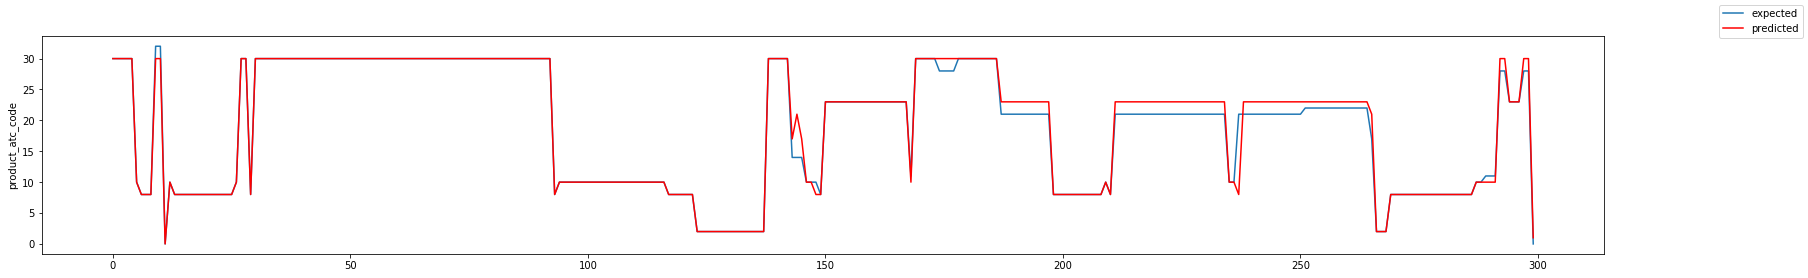

In [32]:
SLICE_START = 400
SLICE_SIZE = 300
SLICE_END = SLICE_START + SLICE_SIZE
fig, axs = plt.subplots(1,len(yColumNames),figsize=(7*4*len(yColumNames),4),sharex=True)

ax1 = axs if len(yColumNames) == 1 else axs[0]
ax1.plot(yTest[SLICE_START:SLICE_END,0],label='expected')
ax1.plot(predictions[SLICE_START:SLICE_END,0],color='r',label='predicted')
ax1.set(ylabel=yColumNames[0])

for i in range(1,len(yColumNames)):
    ax = axs[i-1]
    ax.set(ylabel=yColumNames[i])
    ax.plot(yTest[SLICE_START:SLICE_END,i])
    ax.plot(predictions[SLICE_START:SLICE_END,i],color='r')

fig.legend()
fig.show()